In [1]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import os
import asyncio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt



In [2]:
ALPACAKEY='PKWTRST6I96TSMA0XZQX'
SECRETKEY = 'qtu79fFAmepb9DdU3ehQTftPuZJC9ZY0LlrbECNf'

api_key = ALPACAKEY
secret_key = SECRETKEY

In [269]:
symbols = ["MMM","AOS","ABT","AMAT","T","BA","BSX","BRO","BLDR","COF","KMX","CARR","CAT","CRL","CMG","CI","C","COIN","COST","DAL","DPZ","FDX","FE","F","GEN","GM","IBM","LH","LMT","LOW","LULU","MCHP","MRNA","NTRS","NVDA","PARA","RJF","WMT","DIS","WM","WFC","WDAY"]

In [270]:
# no keys required for crypto data
client = StockHistoricalDataClient(api_key,secret_key)


request_params = StockBarsRequest(
                        symbol_or_symbols=symbols,
                        timeframe=TimeFrame.Hour,
                        start=datetime(2024, 6, 1),
                        end=datetime(2025, 6, 14)
                 )
bars = client.get_stock_bars(request_params)
# convert to dataframe
bars.df
#symbol = asset name
#timestamp
#open = first price of day
#high = highest price of day
#low = lowest price of day
#volume = number of SHARES traded
#trade count = number of individual TRANSACTIONS
#vwap = volume weighted average price


open    high      low     close  \
symbol timestamp                                                       
ABT    2024-06-03 08:00:00+00:00  102.540  103.00  102.540  103.0000   
       2024-06-03 12:00:00+00:00  101.860  102.19  101.860  102.1900   
       2024-06-03 13:00:00+00:00  102.170  103.74  101.920  103.2150   
       2024-06-03 14:00:00+00:00  103.240  104.13  102.450  102.7543   
       2024-06-03 15:00:00+00:00  102.780  103.28  102.680  103.0500   
...                                   ...     ...      ...       ...   
WM     2025-06-13 16:00:00+00:00  238.485  238.65  237.125  237.5100   
       2025-06-13 17:00:00+00:00  237.520  237.61  236.800  236.9400   
       2025-06-13 18:00:00+00:00  236.990  237.10  236.100  236.4300   
       2025-06-13 19:00:00+00:00  236.450  236.71  235.880  236.4400   
       2025-06-13 20:00:00+00:00  236.500  236.50  236.500  236.5000   

                                    volume  trade_count        vwap  
symbol timestamp                                                     
ABT    2024-06-03 08:00:00+00:00     769.0         12.0  102.910680  
       2024-06-03 12:00:00+00:00     747.0          2.0  101.931566  
       2024-06-03 13:00:00+00:00  519757.0       7005.0  102.940037  
       2024-06-03 14:00:00+00:00  497450.0       8933.0  102.919991  
       2024-06-03 15:00:00+00:00  574840.0       7594.0  103.043279  
...                                    ...          ...         ...  
WM     2025-06-13 16:00:00+00:00   87757.0       2727.0  237.745876  
       2025-06-13 17:00:00+00:00   56915.0       2104.0  237.059949  
       2025-06-13 18:00:00+00:00   89792.0       3107.0  236.594503  
       2025-06-13 19:00:00+00:00  339556.0       8087.0  236.231043  
       2025-06-13 20:00:00+00:00  201195.0         73.0  236.500000  

[129945 rows x 7 columns]

In [87]:
import json

In [271]:
stratlog  = []
for i in range(len(symbols)):
    prices = []
    times = []
    for day in bars[symbols[i]]:
        times.append(day.timestamp)
        prices.append(day.open)
    data = {'Hour': times,'Price':prices}
    df = pd.DataFrame(data)

    def MovAvg(dataframe, start, stop):
        df = dataframe[start:stop]
        return df.sum()/(stop-start)

    def ema(dataframe,instance,prev):
        mult = 0.0952
        return df['Price'][instance] * mult + prev*(1-mult)


    tmaLine = []
    # for i in range(20,len(df)):
    #     tmaLine.append(MovAvg(df['Price'],i-20,i))
    tmaLine.append((MovAvg(df['Price'],0,20)))
    for i in range(21,len(df)):
        tmaLine.append(ema(df,i,tmaLine[i-21]))

    fmaLine = []
    # for i in range(50,len(df)):
    #     fmaLine.append(MovAvg(df['Price'],i-50,i))
    fmaLine.append((MovAvg(df['Price'],0,50)))
    for i in range(51,len(df)):
        fmaLine.append(ema(df,i,tmaLine[i-51]))

    tmpadd =  [np.nan] * (len(df) - len(tmaLine)) + tmaLine
    fmpadd =  [np.nan] * (len(df) - len(fmaLine)) + fmaLine
    df['TMA'] = tmpadd
    df['FMA'] = fmpadd

    # Assume df contains columns: 'Price', 'TMA', 'FMA'
    # Calculate the difference between the series
    diff = df['TMA'] - df['FMA']

    # Find where the sign of the difference changes
    sign_change = np.sign(diff).diff()

    # Points where the sign changed (i.e., a crossing occurred)
    cross_indices = sign_change[sign_change != 0].index
    cross_indices = cross_indices[50:]

    # Get intersection points
    intersections = df.loc[cross_indices, ['Hour', 'TMA', 'FMA']]

    dtFormatted = [] #holds dates of intersection as opposed to cross indices which stores hours from start period
    for i in range(len(cross_indices)):
        change = int(cross_indices[i])
        dtFormatted.append(data['Hour'][0]+timedelta(hours=change))

    cross_indices = list(cross_indices)
    while (df['TMA'][cross_indices[0]]-df['FMA'][cross_indices[0]] <= 0):
        del cross_indices[0]
    while (df['TMA'][cross_indices[len(cross_indices)-1]]-df['FMA'][cross_indices[len(cross_indices)-1]] >= 0):
        del cross_indices[len(cross_indices)-1]

    PL = 0

    tradeReturns = []
    for i in range(len(cross_indices)):
        greater = bool(df['TMA'][cross_indices[i]]-df['FMA'][cross_indices[i]] >= 0)
        if greater == True:
            PL -= df['Price'][cross_indices[i]]
            # print("bought at: ",df['Price'][cross_indices[i]])
        else:
            PL += df['Price'][cross_indices[i]]
            # print("sold at: ",df['Price'][cross_indices[i]])
            
            # print("PL from trade: ",df['Price'][cross_indices[i]]-df['Price'][cross_indices[i-1]])
            tradeReturns.append((df['Price'][cross_indices[i]]-df['Price'][cross_indices[i-1]])/df['Price'][cross_indices[i-1]])

    # print("profit over n months: ",PL*2)
    # print("avg trade returns: ",np.mean(tradeReturns))
    stratlog.append(np.mean(tradeReturns))

    


    

with open('big.json', 'w') as file:
      json.dump(stratlog, file)


list(stratlog)






[np.float64(0.00458041192510161),
 np.float64(0.003921026774939298),
 np.float64(0.00013665023565756203),
 np.float64(-0.002084247499099966),
 np.float64(0.0025297703772845523),
 np.float64(0.005900771108926191),
 np.float64(0.0028117329738542446),
 np.float64(0.0001355051892425647),
 np.float64(0.0010586874029217337),
 np.float64(-0.0023747801010911888),
 np.float64(-0.005786141105353908),
 np.float64(0.005241057956198492),
 np.float64(0.007087000096696096),
 np.float64(0.006884464489612709),
 np.float64(-0.010355424048876623),
 np.float64(-0.0020035580415058633),
 np.float64(0.008370498257503762),
 np.float64(-0.00018327282007529638),
 np.float64(0.0036593009996157356),
 np.float64(0.003688552774150013),
 np.float64(-0.0023247983692465195),
 np.float64(-0.006845321762524243),
 np.float64(0.000470781947125152),
 np.float64(-0.0002746991490455833),
 np.float64(0.0032707759205365247),
 np.float64(-0.0009203378362459275),
 np.float64(0.008270266193792467),
 np.float64(0.00517850213231981

In [240]:
prices = []
times = []
for day in bars['META']:
    times.append(day.timestamp)
    prices.append(day.open)
data = {'Hour': times,'Price':prices}
df = pd.DataFrame(data)

def MovAvg(dataframe, start, stop):
    df = dataframe[start:stop]
    return df.sum()/(stop-start)

def ema(dataframe,instance,prev):
    mult = 0.0952
    return df['Price'][instance] * mult + prev*(1-mult)


tmaLine = []
# for i in range(20,len(df)):
#     tmaLine.append(MovAvg(df['Price'],i-20,i))
tmaLine.append((MovAvg(df['Price'],0,20)))
for i in range(21,len(df)):
    tmaLine.append(ema(df,i,tmaLine[i-21]))

fmaLine = []
# for i in range(50,len(df)):
#     fmaLine.append(MovAvg(df['Price'],i-50,i))
fmaLine.append((MovAvg(df['Price'],0,50)))
for i in range(51,len(df)):
    fmaLine.append(ema(df,i,tmaLine[i-51]))

tmpadd =  [np.nan] * (len(df) - len(tmaLine)) + tmaLine
fmpadd =  [np.nan] * (len(df) - len(fmaLine)) + fmaLine
df['TMA'] = tmpadd
df['FMA'] = fmpadd

# Assume df contains columns: 'Price', 'TMA', 'FMA'
# Calculate the difference between the series
diff = df['TMA'] - df['FMA']

# Find where the sign of the difference changes
sign_change = np.sign(diff).diff()

# Points where the sign changed (i.e., a crossing occurred)
cross_indices = sign_change[sign_change != 0].index
cross_indices = cross_indices[50:]

# Get intersection points
intersections = df.loc[cross_indices, ['Hour', 'TMA', 'FMA']]

dtFormatted = [] #holds dates of intersection as opposed to cross indices which stores hours from start period
for i in range(len(cross_indices)):
    change = int(cross_indices[i])
    dtFormatted.append(data['Hour'][0]+timedelta(hours=change))




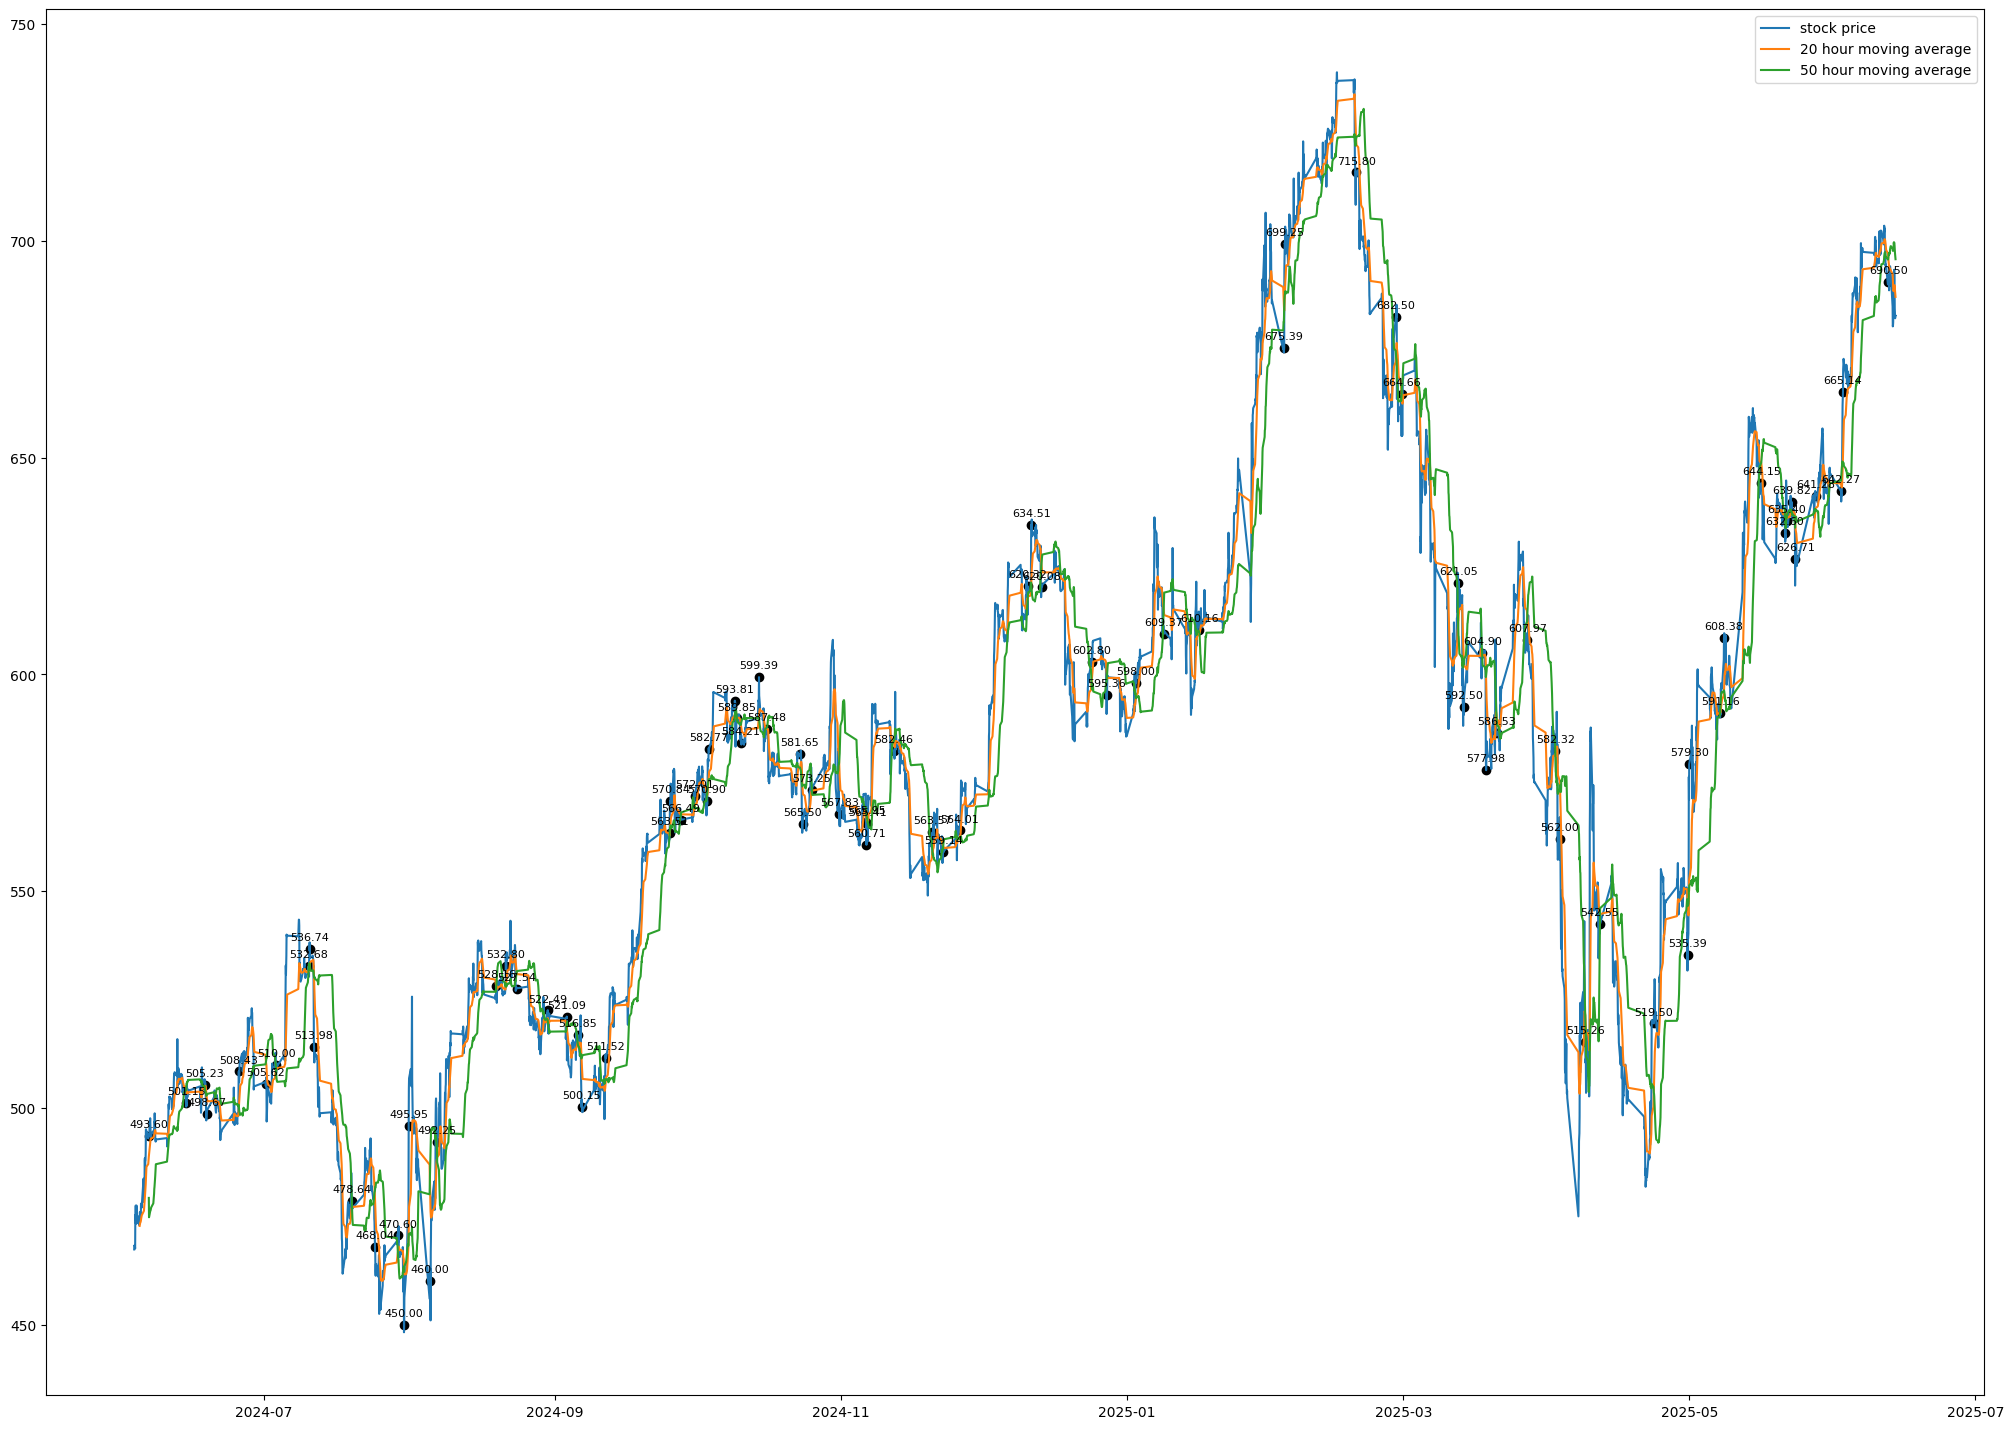

In [241]:
plt.figure(figsize=(25, 18))
plt.plot(data['Hour'],data['Price'], label = 'stock price')
plt.plot(df[20:]['Hour'],tmaLine, label = "20 hour moving average")
plt.plot(df[50:]['Hour'],fmaLine, label = "50 hour moving average")

for i in intersections.iterrows():
    plt.scatter(df['Hour'][i[0]], df['Price'][i[0]], color='black')
    plt.text(df['Hour'][i[0]], df['Price'][i[0]] + 2,             # slight y-offset
    f"{df['Price'][i[0]]:.2f}", color='black', fontsize=8, ha='center')  
   



plt.legend()

In [244]:
stratlog

{'AAPL': np.float64(0.0023391451352526293),
 'MSFT': np.float64(-0.0014830342771960025),
 'META': np.float64(0.005518094267735661),
 'TMUS': np.float64(0.006361106795164931),
 'JPM': np.float64(0.008315754138887478),
 'BAC': np.float64(0.004239278545549014),
 'UNH': np.float64(0.00685404325925759),
 'XOM': np.float64(-0.00011486770096360407),
 'AMZN': np.float64(-0.003513471220697319),
 'NKE': np.float64(-0.0010702316968676788),
 'GE': np.float64(0.013648833869066918)}

In [242]:


cross_indices = list(cross_indices)
while (df['TMA'][cross_indices[0]]-df['FMA'][cross_indices[0]] <= 0):
    del cross_indices[0]
while (df['TMA'][cross_indices[len(cross_indices)-1]]-df['FMA'][cross_indices[len(cross_indices)-1]] >= 0):
    del cross_indices[len(cross_indices)-1]
print(cross_indices)



[50, 145, 175, 184, 245, 303, 337, 395, 401, 415, 513, 558, 604, 628, 643, 680, 709, 844, 877, 916, 986, 1004, 1044, 1056, 1108, 1258, 1261, 1300, 1314, 1353, 1361, 1416, 1426, 1439, 1467, 1493, 1573, 1586, 1618, 1678, 1734, 1736, 1741, 1797, 1898, 1936, 1956, 2109, 2119, 2155, 2259, 2294, 2346, 2408, 2478, 2656, 2660, 2825, 2925, 2946, 3076, 3097, 3127, 3138, 3176, 3246, 3309, 3325, 3382, 3434, 3533, 3618, 3626, 3697, 3708, 3803, 3851, 3862, 3877, 3888, 3912, 3961, 3971, 4091]


In [243]:
PL = 0


tradeReturns = []
for i in range(len(cross_indices)):
    greater = bool(df['TMA'][cross_indices[i]]-df['FMA'][cross_indices[i]] >= 0)
    if greater == True:
        PL -= df['Price'][cross_indices[i]]
        print("bought at: ",df['Price'][cross_indices[i]])
    else:
        PL += df['Price'][cross_indices[i]]
        print("sold at: ",df['Price'][cross_indices[i]])
        
        # print("PL from trade: ",df['Price'][cross_indices[i]]-df['Price'][cross_indices[i-1]])
        tradeReturns.append((df['Price'][cross_indices[i]]-df['Price'][cross_indices[i-1]])/df['Price'][cross_indices[i-1]])

print("profit over n months: ",PL*2)
print("avg trade returns: ",np.mean(tradeReturns))


bought at:  493.6
sold at:  501.15
bought at:  505.23
sold at:  498.6725
bought at:  508.425
sold at:  505.62
bought at:  510.0
sold at:  532.684
bought at:  536.74
sold at:  513.98
bought at:  478.64
sold at:  468.0399
bought at:  470.595
sold at:  450.0
bought at:  495.95
sold at:  460.0
bought at:  492.25
sold at:  528.16
bought at:  532.8
sold at:  527.54
bought at:  522.49
sold at:  521.09
bought at:  516.85
sold at:  500.15
bought at:  511.5192
sold at:  563.5072
bought at:  570.84
sold at:  566.485
bought at:  572.01
sold at:  570.9
bought at:  582.77
sold at:  593.81
bought at:  589.846
sold at:  584.21
bought at:  599.39
sold at:  587.48
bought at:  581.65
sold at:  565.5
bought at:  573.25
sold at:  567.83
bought at:  565.95
sold at:  560.71
bought at:  565.41
sold at:  582.46
bought at:  563.57
sold at:  559.14
bought at:  564.01
sold at:  620.32
bought at:  634.51
sold at:  620.075
bought at:  602.8
sold at:  595.36
bought at:  598.0
sold at:  609.37
bought at:  610.16
sold

In [208]:
stratlog

{'AAPL': np.float64(0.0023391451352526293),
 'MSFT': np.float64(-0.0014830342771960025),
 'META': np.float64(0.005518094267735661),
 'TMUS': np.float64(0.006361106795164931),
 'JPM': np.float64(0.008315754138887478),
 'BAC': np.float64(0.004239278545549014),
 'UNH': np.float64(0.00685404325925759),
 'XOM': np.float64(-0.00011486770096360407),
 'AMZN': np.float64(-0.003513471220697319),
 'NKE': np.float64(-0.0010702316968676788),
 'GE': np.float64(0.013648833869066918)}

In [200]:
with open('large.json', 'w') as file:
      json.dump(stratlog, file)

(array([1., 3., 0., 1., 1., 2., 2., 0., 0., 1.]),
 array([-3.51347122e-03, -1.79724071e-03, -8.10102027e-05,  1.63522031e-03,
         3.35145082e-03,  5.06768132e-03,  6.78391183e-03,  8.50014234e-03,
         1.02163729e-02,  1.19326034e-02,  1.36488339e-02]),
 <BarContainer object of 10 artists>)

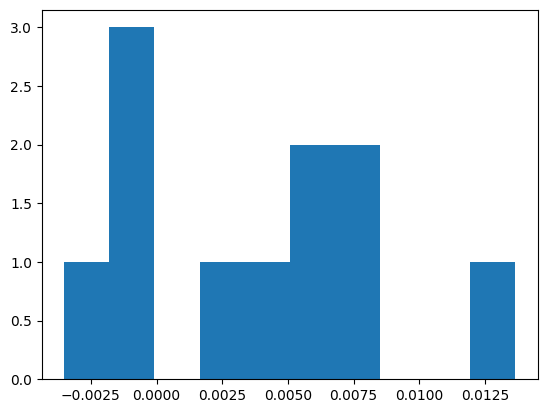

In [211]:
plt.hist(stratlog.values(),bins=10)

72.6085386882569
42


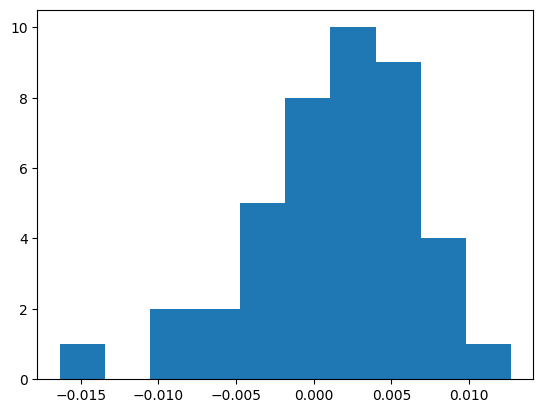

In [284]:
with open('big.json', 'r') as file:
    data = json.load(file)
    plt.hist(data)
    print(np.mean(data)*50 *1000)
    print(len(data))